# Differential Event Rate

It is derived as the duration distribution of microlensing events:
\begin{equation}
\frac{d\Gamma_{\rm PBH}}{d\hat{t}} = 2 \frac{\Omega_{\rm PBH}}{\Omega_{\rm DM}} 
\int_0^{d_s} dd_L \int_0^{u_T(d_L, M_{\rm PBH})} du_{\min} \,
\frac{1}{\sqrt{u_T^2(d_L, M_{\rm PBH}) - u_{\min}^2}}  \,
\frac{\rho_{\rm DM}(d_L)}{M_{\rm PBH} v_c^2(d_L)} \, 
v^4 \exp\left[-\frac{v^2}{v_c^2(d_L)}\right],
\end{equation}
$\quad \text{donde} \quad v = \frac{2 R_E \sqrt{u_T^2 - u_{\min}^2}}{\hat{t}}$.


The profile describing the halo objects of the galaxy will be given by Navarro Frenk and White:
\begin{equation}
    \rho_{NFW}(R) =  \frac{\rho_{c}}{(\frac{r}{r_s})(\frac{r}{r_s}+1)^2} \,,
\end{equation}
with $\rho_{\odot} = 0.0097M_{\odot}\text{pc}^{-3}$, $R_C= 5$ kpc as the core radius of the galaxy, and $R_{Sol}=8.5$ kpc as the distance from the Sun to the center of the galaxy.

On the other hand, $v_E = R_E(x)/t_E$.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as C
import scipy.integrate as integrate
from scipy.integrate import simpson, dblquad
from event_rate import dif_event_rate, integrand_jax,integrand_jax_m31, double_integral_2d
from tqdm import tqdm
import time
import os
import jax
import jax.numpy as jnp
os.environ["JAX_PLATFORM_NAME"] = "gpu"
print("Plataforma por defecto:", jax.default_backend())
print("Dispositivos disponibles:", jax.devices())
jax.config.update("jax_enable_x64", True)

Plataforma por defecto: gpu
Dispositivos disponibles: [CudaDevice(id=0)]


In [2]:
rho_c_MW = 4.88e6*C.M_sun/u.kpc**3
rs_MW = 21.5*u.kpc
rho_c_M31 = 4.96e6*C.M_sun/u.kpc**3
rs_M31 = 25*u.kpc
uT = 1
l,b = 121.2, -21.6 
D = 770*u.kpc
# m = 10**-7*u.M_sun
t=1*u.hour

masses = np.logspace(-12,-7,12-7+1)*u.M_sun
m = masses[-1]

In [3]:
# integrar sin jax
not_jax = False
if not_jax:
    d2gamadt2_MW = []
    d2gamadt2_M31 = []
    for t in tqdm(t_hat):
        d2gamadt2_MW.append(dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT).event_rate())
        d2gamadt2_M31.append(dif_event_rate( t, m, D, rs_M31, rho_c_M31, l, b, uT).event_rate())
    
    
    plt.figure(figsize=(8,6))
    plt.plot(t_hat,(np.array(d2gamadt2_MW)+np.array(d2gamadt2_M31)),lw=2, ls='-',color='r',label=str(m.value)+r'$M_{\odot}$')
    plt.plot(t_hat,np.array(d2gamadt2_MW), alpha=0.5,lw=2, ls='--',color='b')
    plt.plot(t_hat,np.array(d2gamadt2_M31), alpha=0.5,lw=2, ls='--',color='g')
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-8,1e-2)
    
    plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
    plt.xlabel(r'$t_E [days]$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='best' ,fontsize=15)


In [4]:
# double_integral_2d_jit = jax.jit(double_integral_2d, static_argnames=["f"])

In [5]:

f_jax = lambda u, x: integrand_jax_m31(u, x, D=D.to('m').value, rs=rs_MW.to('m').value, rho_c=rho_c_MW.to('kg/m^3').value,
                                   t=float(t.to('s').value), m=m.to('kg').value, l_coord=l,
                                   b_coord=b, uT=uT)

t0 = time.time()
event_rate_data = dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT, False)
print('resultado integrando',event_rate_data.integrand(0.5,0.5))
print('resultado integral usando dbquad',event_rate_data.event_rate())
tf = time.time()
print('Tiempo transcurrido integrando con dbquad',tf-t0)
print('   ')
t0 = time.time()
resultado_jax = double_integral_2d(f_jax, (0.0, uT-1e-15), (0.0, 1.0-1e-9))
print('resultado integrando usando JAX',integrand_jax_m31(0.5, 0.5, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
print('resultado integral usando JAX',resultado_jax)
tf = time.time()
print('Tiempo transcurrido integrando con JAX',tf-t0)


resultado integrando 8.956820816943451e-32
resultado integral usando dbquad 3.45288282217943e-07
Tiempo transcurrido integrando con dbquad 1.3025925159454346
   
resultado integrando usando JAX 8.956820816943577e-32
resultado integral usando JAX 3.454676912048562e-07
Tiempo transcurrido integrando con JAX 1.7535693645477295


In [6]:
f_jax = lambda u, x: integrand_jax(u, x, D=D.to('m').value, rs=rs_MW.to('m').value, rho_c=rho_c_MW.to('kg/m^3').value,
                                   t=float(t.to('s').value), m=m.to('kg').value, l_coord=l,
                                   b_coord=b, uT=uT)
t0 = time.time()
event_rate_data = dif_event_rate( t, m, D, rs_MW, rho_c_MW, l, b, uT, True)
print('resultado integrando',event_rate_data.integrand(0.5,0.5))
print('resultado integral usando dbquad',event_rate_data.event_rate())
tf = time.time()
print('Tiempo transcurrido integrando con dbquad',tf-t0)
print('   ')
t0 = time.time()
resultado_jax = double_integral_2d(f_jax, (0.0, uT-1e-15), (0.0, 1.0))
print('resultado integrando usando JAX',integrand_jax(0.5, 0.5, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
print('resultado integral usando JAX',resultado_jax)
tf = time.time()
print('Tiempo transcurrido integrando con JAX',tf-t0)


resultado integrando 6.119038840901917e-32
resultado integral usando dbquad 1.388623456166031e-07
Tiempo transcurrido integrando con dbquad 3.6873531341552734
   
resultado integrando usando JAX 6.119038840902131e-32
resultado integral usando JAX 1.3885964528176913e-07
Tiempo transcurrido integrando con JAX 0.23954439163208008


/home/anibal-pc/Lentes_gravitacionales/event_rate.py:110: RuntimeWarning: divide by zero encountered in divide
  return (2*f*u.hour*u.hour*self.D*(1/u_factor)*rho*exp_fac*Q*vr**2  /self.m ).decompose()
/home/anibal-pc/anaconda3/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


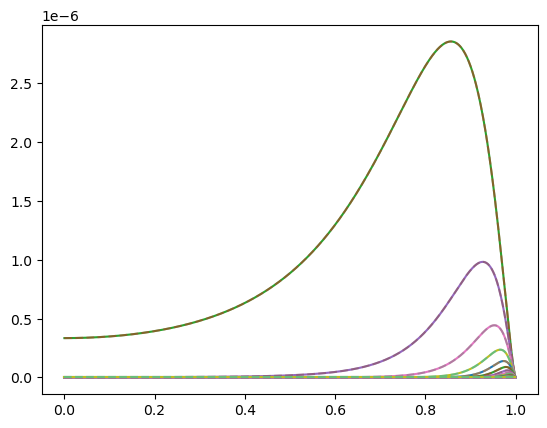

/home/anibal-pc/Lentes_gravitacionales/event_rate.py:179: RuntimeWarning: divide by zero encountered in scalar divide
  rho = rho_c / (c * (1 + c)**2)


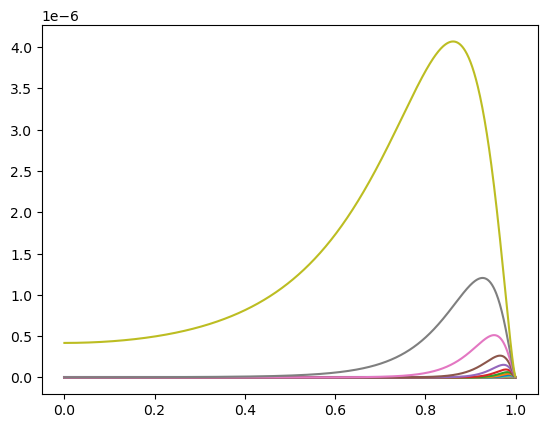

In [7]:
#comparacion integrandos
umin = np.linspace(0,1,1000)
X = np.linspace(0,1,30)
for x in X:
    plt.plot(umin,integrand_jax(umin, x, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))
    plt.plot(umin, event_rate_data.integrand(x,umin),'--',alpha=0.5)
plt.show()

for x in X:
    plt.plot(umin,integrand_jax_m31(umin, x, D.to('m').value, rs_MW.to('m').value, rho_c_MW.to('kg/m^3').value, float(t.to('s').value), m.to('kg').value, l, b, uT))



In [8]:
# str(m)

In [23]:
# Convertís tus cantidades antes:
# m_val = m.to('kg').value

t_hat = np.logspace(-3, 2, 200)*u.hour.to('s')

rs_MW_val = rs_MW.to('m').value
rho_c_MW_val = rho_c_MW.to('kg/m^3').value

rs_M31_val = rs_M31.to('m').value
rho_c_M31_val = rho_c_M31.to('kg/m^3').value

D_val = D.to('m').value

l_val = l
b_val = b
uT_val = uT
# Definís la función con los parámetros fijos
d2gamadt2_MW = {str(m):[] for m in masses}
d2gamadt2_M31 = {str(m):[] for m in masses}
for m in masses: 
    m_val = m.to('kg').value

    for t_val in tqdm(t_hat):
        f_jax_MW = lambda u, x: integrand_jax(u, x, D=D_val, rs=rs_MW_val, rho_c=rho_c_MW_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
        
        # Definís la función con los parámetros fijos
        f_jax_M31 = lambda u, x: integrand_jax_m31(u, x, D=D_val, rs=rs_M31_val, rho_c=rho_c_M31_val,
                                           t=t_val, m=m_val, l_coord=l,
                                           b_coord=b, uT=uT_val)
        
        resultado_MW = double_integral_2d(f_jax_MW, (0.0, uT-1e-15), (0.0, 1.0))
        resultado_M31 = double_integral_2d(f_jax_M31, (0.0, uT-1e-15), (0.0, 1.0-1e-9))
        
        d2gamadt2_MW[str(m)].append(resultado_MW)
        d2gamadt2_M31[str(m)].append(resultado_M31)


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 48.83it/s]


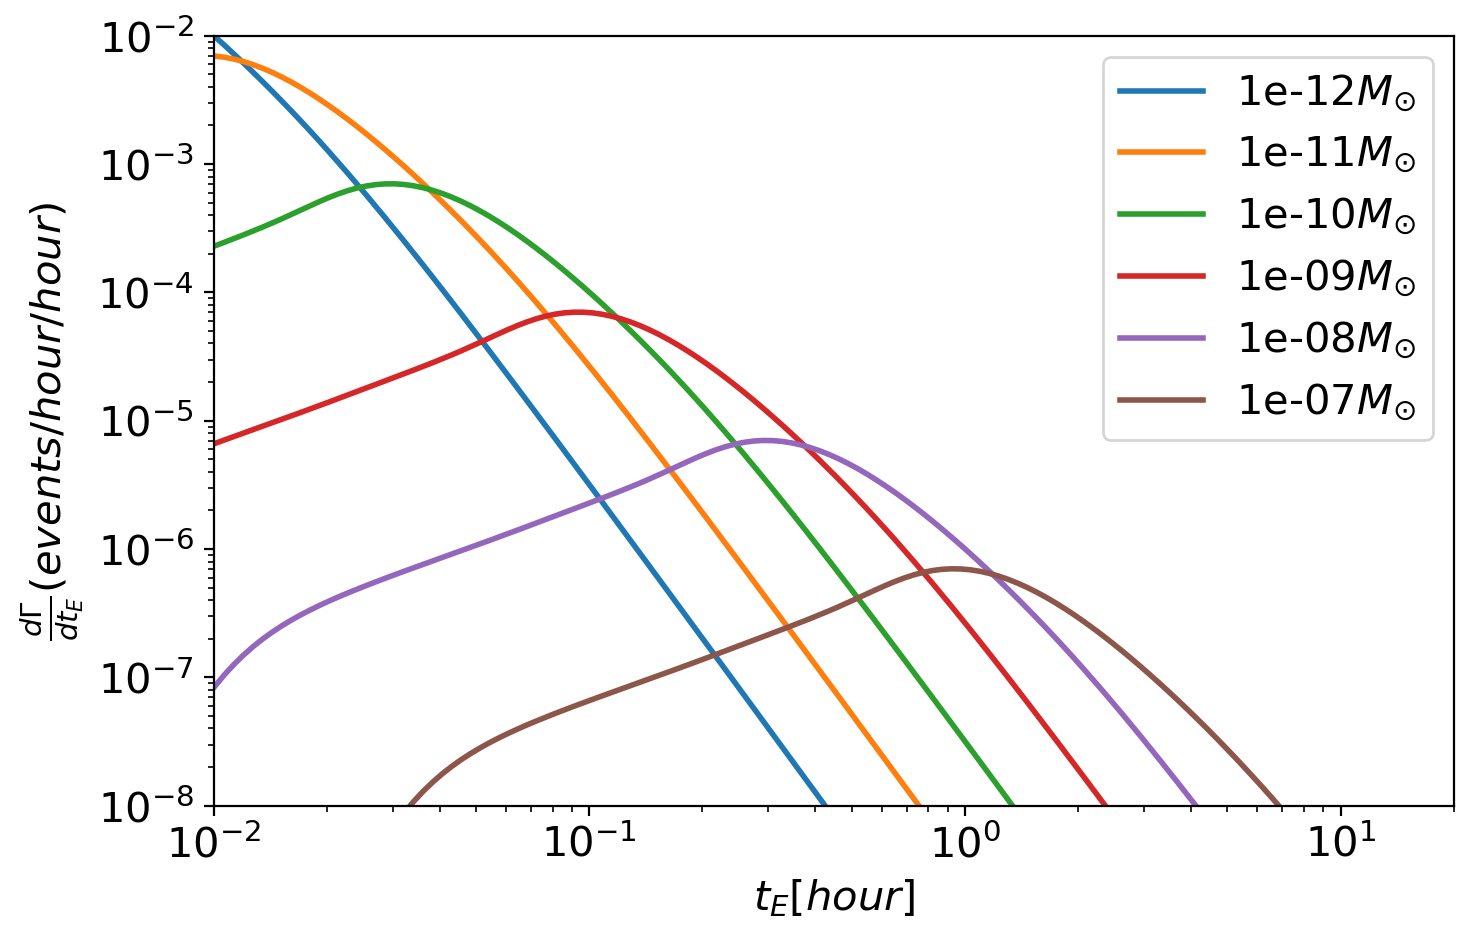

In [26]:
#niikura plots

plt.figure(figsize=(8,5),dpi=200)
for m in masses: 
    plt.plot(t_hat/3600,(np.array(d2gamadt2_MW[str(m)])+np.array(d2gamadt2_M31[str(m)])),lw=2, marker='',ls='-',label=str(m.value)+r'$M_{\odot}$')
# plt.plot(t_hat/3600,np.array(d2gamadt2_MW[str(m)]), alpha=0.5,lw=2, ls='--',color='b')
# plt.plot(t_hat/3600,np.array(d2gamadt2_M31[str(m)]), alpha=0.5,lw=2, ls='--',color='g')
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-8,1e-2)
plt.xlim(1e-2,2e1)

plt.ylabel(r'$\frac{d\Gamma}{dt_E}(events/hour/hour)$',fontsize=15)
plt.xlabel(r'$t_E [hour]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best' ,fontsize=15)
plt.savefig('/home/anibal-pc/figures_final_makler/rates_niikura.png')
plt.show()

In [16]:

# result = double_integral_2d(f_jax, (0.0, uT-1e-16), (0.0, 1.0-1e-9))
# print("Resultado integración trapezoidal JAX:", result)